In [167]:
# 代码运行环境
%load_ext watermark
%watermark -p torch,numpy,sklearn -v -m

CPython 3.6.1
IPython 6.0.0

torch 0.1.12_2
numpy 1.12.1
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.38)
system     : Darwin
release    : 16.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [30]:
%matplotlib inline

In [31]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.metrics as metrics
import numpy as np

## 数据分布的概念
- $P(X)$
    - 本质上就是一个函数，值域(Range)固定在 [0, 1]。定义域及映射决定了这个「分布」 
    - 就其一般形式，$X$ 只要是一个集合即可。机器学习中常用的就是 $\mathbb{R}^N$ 即 N 维数组

### 简单的二分类数据分布

In [3]:
class0_data = np.random.rand(200, 2)
class1_data = np.random.rand(200, 2) + 3

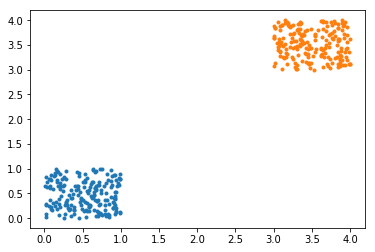

In [4]:
plt.plot(class0_data[:, 0], class0_data[:, 1], '.', class1_data[:, 0], class1_data[:, 1], '.');

上面这个例子是来自 $\mathbb{R}^2$ 的两类数据的「分布」，即 $P(X|y=0)$ 及 $P(X|y=1)$

## Discriminative vs Generative model

Generative Model（以下简称 GM）的典型例子是朴素贝叶斯，通过 GM 可以计算 $P(X, y)$ 的联合分布。Discriminative Model（以下简称DM）的典型例子是 Logistic Regression，其只能直接得到 $P(y|X)$。
- 对 GM 来说，得到 $P(X|y)$ 其实也就意味着得到了联合分布 $P(X, y)$，反之亦然。因为先验分布 $P(y)$ 往往很容易统计或者知道。
  - 得到 $P(X|y)$ 之后，通过贝叶斯公式即可得到 $P(y|X) = \frac{P(X|y)P(y)}{\sum_k P(X|y_k)P(Y_k)}$，$k$ 为 $y$ 的类别数
- 而对 DM 来说，得到 $P(y|X)$ 并没有办法通过概率公式反推联合分布 $P(X,y)$，因为 $P(X)$ 对高维输入来说往往难以通过记数进行准确估计

GM 相当于有更丰富的输入分布信息，因此 GM 可以对输入进行采样，得到有意义的输入，比如在 $P(X|y=1)$ 中采样得到一个典型的「正例」样本。但这也对模型提出了更多的要求和假设。

> "one should solve the [classification] problem directly and never solve a more general problem as an intermediate step [such as modeling p(xly)]." -- Vapnik

References:
- Pluskid, Discriminative Modeling vs Generative Modeling. http://freemind.pluskid.org/machine-learning/discriminative-modeling-vs-generative-modeling/
- Andrew Y. Ng and Michael I. Jordan. 2002. On discriminative vs. generative classifiers: A comparison of logistic regression and naive bayes. In T. G. Dietterich, S. Becker, & Z. Ghahramani, eds. Advances in neural information processing systems 14. MIT Press, 841–848.

上面的二类数据分布看起来很好区分，因为两类数据的概率分布几乎没有「重叠」。事实上只要两类数据的概率分布不是完全重叠，他们还是可以有一定区分力的。

In [9]:
def truncated_norm(lower, upper, mu, sigma):
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    return stats.truncnorm(a, b, loc=mu, scale=sigma)

real_data = truncated_norm(0, 1, 0.5, 0.2).rvs(1000)
noise_data = stats.uniform(loc=0, scale=1).rvs(1000)

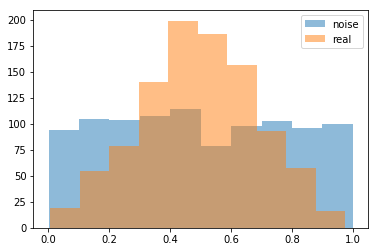

In [12]:
plt.hist(noise_data, alpha=0.5, label='noise');
plt.hist(real_data, alpha=0.5, label='real');
plt.legend();

可以看到真实的分布（假设为正例）在 0.5 附近有更高的概率，因此可以设计一个简单的分类器，在 0.5 附近的点返回 1

In [30]:
def dummy_classify(x):
    return np.abs(x - 0.5) < 0.2

In [31]:
y_pred = dummy_classify(np.concatenate((real_data, noise_data)))
y_true = [1] * len(real_data) + [0] * len(noise_data)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_true, y_pred)

0.64800000000000002

可以看到，这样一个分类器也能获得一个比随机好的效果。

## Generative Adversarial Nets (GANs)

![Album from NIPS 2016 Workshop on Adversarial Training](imgs/nips-2016-gan-album.jpg)
Photo from https://sites.google.com/site/nips2016adversarial/

GANs 的思想是让一个 DM 和一个 GM 进行对抗。其整体优化目标是:
    
$$ \min_G\max_D V(D, G) = E_{x \sim P_{data}(x)}[\log D(x)] + E_{z \sim P_z(z)}[\log (1 - D(G(z))]$$

- 这个优化目标可以拆成两个部分来看：
    - 对 DM 来说，其输入来自两个分布，即 $x \sim P_{data}(x)$ 及 $z \sim P_z(z)$
        - 如果只看 $x \sim P_{data}(x)$，那么 DM 面对的就是一个普通的二分类问题
        - $z \sim P_z(z)$ 是 GM 的输入分布，GM 会对该输入进行变换，变换之后的数据分布会和 $P_{data}$ 很像，即起到「伪造」的效果。而 DM 的另一个目标就是识别出这种「伪造」
    - 对 GM 来说，目标就是「伪造」出和 $P_{data}$ 很像的分布。伪造的方法是从一个先验分布 $P_z$ 中采样数据，进行变换之后使之很像 $P_{data}$
    
[1] 中提供了一个很形象的图来表示这个过程，其中 Input Generator 对应为在 $P_z$ 中采样，由于 $P_z$ 完全是一个先验分布（如 Uniform Distribution)，其提供的数据是毫无「意义」的。而 GM 的作用就是「化腐朽为神奇」，将无意义的输入「伪造」成一个有意义的模式，让 DM 难以识别。

![image.png](imgs/medium-blog-gan-figure.png)

这个过程也可以想像成古董鉴定家和古董造假家的博弈过程。鉴定家一开始很容易就鉴定出造假的古董，造假家为了避免被识破，努力提高自己的姿势水平。随着造假家水平的提高，鉴定家也逐渐变得真假莫辨。

References:
- [1] Dav Nag, Generative Adversarial Networks (GANs) in 50 lines of code (PyTorch) https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f


### PyTorch 中的实现

下面在 PyTorch 中实现一个简单的 GANs。

In [242]:
# 产生一组数据，模型不知道数据怎么产生的。
data_num = 1000
# x ~ [-1, 1]
circle_x = (np.random.rand(data_num) - 0.5) * 2
# y ~ sqrt(1 - x^2)
# to generate a circle
circle_y = np.random.choice([-1, 1], data_num) * np.sqrt(1 - circle_x ** 2)

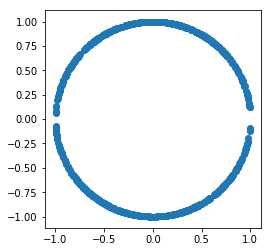

In [243]:
fig, axes = plt.subplots(1)
axes.scatter(circle_x, circle_y)
axes.set_aspect('equal')

In [244]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [245]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.params = nn.Sequential(nn.Linear(input_dim, 128),
                                    nn.LeakyReLU(),
                                    nn.Linear(128, 128),
                                    nn.LeakyReLU(),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())
        
    def forward(self, input):
        return self.params(input)

In [246]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()        
        self.params = nn.Sequential(nn.Linear(input_dim, 128),
                                   nn.LeakyReLU(),
                                   nn.Linear(128, 128),
                                   nn.LeakyReLU(),
                                   nn.Linear(128, output_dim),
                                    nn.Tanh())
    def forward(self, input):
        return self.params(input)

In [247]:
dm = Discriminator(2)
gm = Generator(2, 2)

In [248]:
sample_data = Variable(torch.rand(5, 2), volatile=True)

In [249]:
# DM will output probabilty
dm(sample_data)

Variable containing:
 0.4938
 0.4885
 0.4914
 0.4905
 0.4918
[torch.FloatTensor of size 5x1]

In [250]:
# GM will output faked 2-D data
gm(sample_data)

Variable containing:
 0.0064 -0.1813
 0.1040 -0.1991
 0.0498 -0.1572
 0.0652 -0.1601
 0.0341 -0.1700
[torch.FloatTensor of size 5x2]

In [251]:
real_data = torch.FloatTensor(np.hstack((circle_x[:, np.newaxis], circle_y[:, np.newaxis])))
print(real_data.size())

torch.Size([1000, 2])


In [252]:
criterion = nn.BCELoss() # binary cross entropy loss
d_optimizer = torch.optim.Adam(dm.parameters())
g_optimizer = torch.optim.Adam(gm.parameters())

In [258]:
num_epochs = 2000
data_num = 1000

d_loss = []
g_loss = []
for epoch in range(num_epochs):
    # Optimize DM on real data
    dm.zero_grad()
    real = Variable(real_data)
    d_preds = dm(real)
    real_loss = criterion(d_preds, Variable(torch.ones(data_num)))        
    real_loss.backward()

    # Optimize DM on fake data
    noise = Variable(torch.FloatTensor(data_num, 2))
    noise.data.normal_(0, 1)        
    g_fake = gm(noise)
    # !important
    # need to detach here, we only want to optimize DM in this loop    
    d_fake_preds = dm(g_fake.detach())
    fake_loss = criterion(d_fake_preds, Variable(torch.zeros(data_num)))
    fake_loss.backward()
    d_optimizer.step()
    
    if d_step == k - 1:
        d_loss.append((real_loss + fake_loss).data[0])
        
    # Optimize GM
    gm.zero_grad()
    d_fake_preds = dm(g_fake)
    # Notice the difference here, GM wants to trick DM
    loss = criterion(d_fake_preds, Variable(torch.ones(data_num)))
    g_loss.append(loss.data[0])
    loss.backward()
    g_optimizer.step()

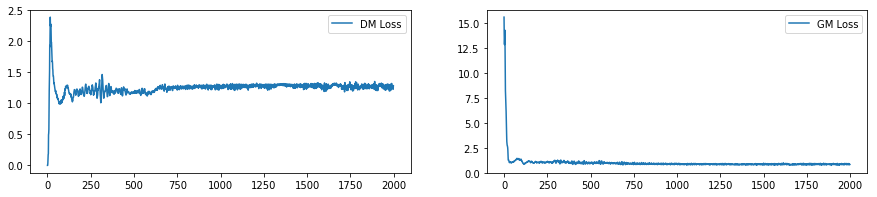

In [259]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
axes[0].plot(range(len(d_loss)), d_loss, label='DM Loss')
axes[0].legend()
axes[1].plot(range(len(g_loss)), g_loss, label='GM Loss')
axes[1].legend();

训练之后，来看一下 G 现在生成的东西

In [265]:
g_input = Variable(torch.FloatTensor(data_num, 2))
g_input.data.normal_(0, 1)  
g_fake = gm(g_input)

In [266]:
g_input

Variable containing:
 1.3043 -0.2850
 0.5215 -2.9183
-0.6754  1.8650
       ⋮        
-0.2291 -0.4549
 0.1966  1.0901
-2.4336 -1.0370
[torch.FloatTensor of size 1000x2]

In [267]:
gm_init = Generator(2, 2)
g_fake_init = gm_init(g_input)

In [268]:
g_input_data = g_input.data.numpy()
g_fake_data = g_fake.data.numpy()
g_fake_init_data = g_fake_init.data.numpy()

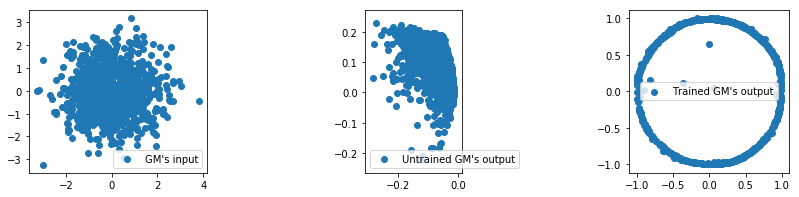

In [269]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].scatter(g_input_data[:, 0], g_input_data[:, 1], label="GM's input")
axes[1].scatter(g_fake_init_data[:, 0], g_fake_init_data[:, 1], label="Untrained GM's output")
axes[2].scatter(g_fake_data[:, 0], g_fake_data[:, 1], label="Trained GM's output")
for ax in axes:
    ax.set_aspect('equal')
    ax.legend()

## Conditional GANs
以 mnist dataset 为例，解释 Conditional GANs

### MNIST 数据集读取
- 一个著名的手写数字数据集

In [77]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import os

In [78]:
if not os.path.exists('./data'):
    os.mkdir('./data')
    
train_set = dset.MNIST(root='./data', train=True, 
                       transform=transforms.Compose([transforms.ToTensor(),                                        
                                                     transforms.Normalize((0.5,), (1.0,))]),
                       download=True)

In [70]:
dataloader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True)

Take a look at the data

In [71]:
data_sample = next(iter(dataloader))

- dataloader 迭代返回的每个元素是一个 list, 其第一个元素是这批 batch 的图像，第二个元素是这批 batch 的 label
- 第一个元素是一个 FloatTensor, 大小为 (200 x 1 x 28 x 28)，即 (batch_size x channel x height x width)。因为是灰度图像，所以只有一个 channel
- 因为 channel 这个维度没用，所以我们用 view 把它消解

In [72]:
print(data_sample[0].size())
print(data_sample[0].view(-1, 28, 28).size())

torch.Size([200, 1, 28, 28])
torch.Size([200, 28, 28])


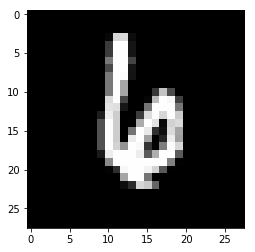

In [74]:
plt.imshow(data_sample[0].view(-1, 28, 28)[0].numpy(), cmap='gray');

对于这样一个数据集，我们想用 GANs 的 Generator 自己产生对应的数字。如果用原始的 GANs 形式，需要针对 0-9 这 10 个数字产生对应 10 组模型。对更多类的问题，需要的模型会更多。而且各个模型之间互相独立，没有办法「共享」一部分他们学习的知识，这不是一个很好的解决方案。

针对这个问题，Conditional GANs [1] 给出的方案是除了噪音输入 Z，给将每一个 $y$ 的信息也输入给 DM 及 GM（比如 embedding 形式）。其模型示意图（取自 [1]）及问题形式如下：

![](./imgs/mirza-arxiv-14.png)

$$ \min_G\max_D V(D, G) = E_{x \sim P_{data}(x|y)}[\log D(x)] + E_{z \sim P_z(z)}[\log (1 - D(G(z|y))]$$

参考文献
- [1] M. Mirza and S. Osindero. 2014. Conditional Generative Adversarial Nets. ArXiv e-prints (November 2014).

下面把之前的代码改成支持 Conditional Input (y)。这里我们对 Y 查 embedding，将其与 noise 用 concat 的方式拼在一起。

D 和 G 的 Y embedding 不共享

In [307]:
class ConDiscriminator(nn.Module):
    def __init__(self, input_dim, y_embed_dim):
        super(ConDiscriminator, self).__init__()
        self.y_embedding = nn.Embedding(10, y_embed_dim)
        self.params = nn.Sequential(nn.Linear(input_dim + y_embed_dim, 256),
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid())
        
    def forward(self, z, y):
        y_embed = self.y_embedding(y)
        concat = torch.cat((z, y_embed), dim=1)
        return self.params(concat)
        
class ConGenerator(nn.Module):
    def __init__(self, input_dim, y_embed_dim, output_dim):
        super(ConGenerator, self).__init__()
        self.y_embedding = nn.Embedding(10, y_embed_dim)
        self.params = nn.Sequential(nn.Linear(input_dim + y_embed_dim, 512),
                                   nn.LeakyReLU(),
                                   nn.Linear(512, output_dim),
                                   nn.Tanh())
    def forward(self, z, y):
        y_embed = self.y_embedding(y)
        concat = torch.cat((z, y_embed), dim=1)
        return self.params(concat)

In [318]:
z_dim = 128
y_embed_dim = 128
image_dim = 28 * 28
cdm = ConDiscriminator(image_dim, y_embed_dim)
cgm = ConGenerator(z_dim, y_embed_dim, image_dim)
criterion = nn.BCELoss() # binary cross entropy loss
cd_optimizer = torch.optim.Adam(cdm.parameters(), lr=0.0002, betas=(0.5, 0.999))
cg_optimizer = torch.optim.Adam(cgm.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [336]:
# 本人电脑上运行 20 分钟左右
num_epochs = 40

d_loss = []
g_loss = []

for i in range(num_epochs):
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
    for batch_id, (image, label) in enumerate(dataloader, 1):
        data_num = len(label)
        cdm.zero_grad()
        
        real = Variable(image.view(-1, 28 * 28))
        label = Variable(label)
        
        # Train D on real data
        d_preds = cdm(real, label)
        real_loss = criterion(d_preds, Variable(torch.ones(data_num)))        
        real_loss.backward()

        # Train D on fake data
        noise = Variable(torch.FloatTensor(data_num, z_dim))
        noise.data.normal_(0, 1)        
        g_fake = cgm(noise, label)
        d_fake_preds = cdm(g_fake.detach(), label)
        fake_loss = criterion(d_fake_preds, Variable(torch.zeros(data_num)))
        fake_loss.backward()

        if d_step == k - 1:
            d_loss.append((real_loss + fake_loss).data[0])
        cd_optimizer.step()

        # Optimize GM
        cgm.zero_grad()
        d_fake_preds = cdm(g_fake, label)
        # Notice the difference here, GM wants to trick DM
        loss = criterion(d_fake_preds, Variable(torch.ones(data_num)))
        loss.backward()        
        g_loss.append(loss.data[0])
        cg_optimizer.step()

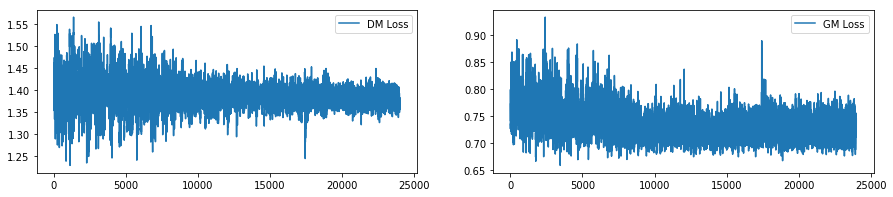

In [337]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
axes[0].plot(range(len(d_loss)), d_loss, label='DM Loss')
axes[0].legend()
axes[1].plot(range(len(g_loss)), g_loss, label='GM Loss')
axes[1].legend();

查看生成的结果

In [ ]:
ar = [None] * 10
for i in range(10):
    g_input = Variable(torch.FloatTensor(1, z_dim))
    g_input.data.normal_(0, 1)       
    g_fake = cgm(g_input, Variable(torch.LongTensor([i]))).view(28, 28)
    ar[i] = g_fake.data.numpy()

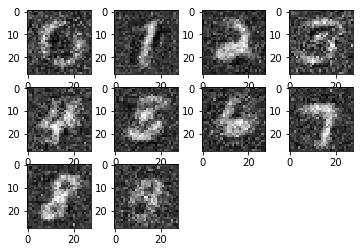

In [357]:
fig, axes = plt.subplots(nrows=3, ncols=4)
for i in range(10):
    row = int(i / 4)
    col = i % 4
    axes[row, col].imshow(ar[i], cmap='gray')
for unused in [10, 11]:
    fig.delaxes(axes.flatten()[unused])

## IR GAN
- 文章中提了 Web Search, item recommendation 及 QA 三个任务，三者的原理是一样的，这里以 item recommendation 为例

GAN 用于文本生成上的问题：

- 图像的例子中，给定 GM 一个随机数，GM 跑出的结果直接作为 DM 的输入，整个过程是可导的。
- 文本对 GM 的输出有一个「离散化」的过程，如取 argmax，或根据分布采样，这个过程是不可导的，会导致导数在此处断开。

https://www.quora.com/Is-text-generation-using-GANs-a-fundamentally-flawed-idea/answer/Ian-Goodfellow
> Is text generation using GANs a fundamentally flawed idea?

Ian Goodfellow: 

It is not a fundamentally flawed idea. It should be possible to do at least one of the following:

- Back-propagate through the discrete sampling process using the REINFORCE algorithm.
- Optimize the discrete variables using either the concrete distribution or Gumbel-softmax.
- Train the GAN to generate continuous embedding vectors rather than discrete tokens.

There might be more ways of doing it that I haven’t thought of.

- REINFORCE algorithm: IRGAN 作者之前的工作 SeqGAN [1]，以及 IRGAN [2]
- Gumbel-softmax: [3]
- Embedding vectors: 还没看到？

参考文献
- [1] L. Yu, W. Zhang, J. Wang, and Y. Yu. 2016. SeqGAN: Sequence Generative Adversarial Nets with Policy Gradient. ArXiv e-prints (September 2016).
- [2] Jun Wang et al. 2017. IRGAN: A minimax game for unifying generative and discriminative information retrieval models. In SIGIR 2017.
- [3] M. J. Kusner and J. M. Hernández-Lobato. 2016. GANS for Sequences of Discrete Elements with the Gumbel-softmax Distribution. ArXiv e-prints (November 2016).

### IR GAN 的架构

- DM 没啥可说的，一般就是神经网络，在 item recommendation 里更简单，就是 user, item 的向量，以及 item 的 bias
    - $s_\phi(u, i) = b_i + v_u^T v_i$
- GM:
    从之前的内容可以看到，图像上的 GAN 的 Generator 输入都是某个先验分布 $P_z$ 的随机数。这也给 Generator 带来很大好处，不需要做 softmax 之类的归一化，也不需要用 MCMC 之类的方法做采样。但是 IRGAN 里的 GM 则比较「暴力」。其 GM 是以 DM 为基础加上 softmax 产生的（是指 DM 的架构，参数并不共享）
    - $P(i|u) = \frac{exp(s_\theta(u, i)/\tau)}{\sum_{i \in I} exp(s_\theta(u, i)/\tau)}$

可以看出，其 GM 输入不在是随机数，而是用同 DM 架构的模型进行打分，然后再进行归一化成概率，从而得到当前 user 下所有 item 的概率分布。

这样做的原因是 IRGan 要保证 GM 生成的东西是一个合法的 item，而不能像图像那样随意生成一个向量，因此他的做法是根据这个分布在 item 上进行采样，以生成负例。而这个采样的过程就使得导数在此处断开了。

而为了解决导数断开的问题，在更新 GM 的时候，IR GAN 使用了增强学习中的 Policy Gradient 方法来更新梯度（其实和 BP 差不多，可以参考 http://karpathy.github.io/2016/05/31/rl/ 中的介绍）